1) Use a técnica de regressão linear multinível vista para o dataset da aula2. Compare os modelos e analise o melhor de acordo com o ELPD LOO. Inclua, para efeito de comparação, um modelo de regressão linear que use o mesmo intercepto e inclinação para todos os dados. Use os mesmos preditores da aula 2.



In [ ]:
!wget https://raw.githubusercontent.com/romefeller/predictive/main/dados/yield_df.csv

--2025-03-16 19:58:50--  https://raw.githubusercontent.com/romefeller/predictive/main/dados/yield_df.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1565376 (1.5M) [text/plain]
Saving to: ‘yield_df.csv’

yield_df.csv        100%[===================>]   1.49M  5.44MB/s    in 0.3s    

2025-03-16 19:58:51 (5.44 MB/s) - ‘yield_df.csv’ saved [1565376/1565376]



In [ ]:
import pandas as pd
import pymc as pm
import numpy as np



In [ ]:
df = pd.read_csv("yield_df.csv")
display(df)

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...,...
28237,28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


In [ ]:
valores_vazios = df.isnull()
valores_sem_info = df.isna().sum()
print('\n Valores Vazios:', valores_vazios)
print('\n linhas sem informações', valores_sem_info)


 Valores Vazios:        Unnamed: 0   Area   Item   Year  hg/ha_yield  \
0           False  False  False  False        False   
1           False  False  False  False        False   
2           False  False  False  False        False   
3           False  False  False  False        False   
4           False  False  False  False        False   
...           ...    ...    ...    ...          ...   
28237       False  False  False  False        False   
28238       False  False  False  False        False   
28239       False  False  False  False        False   
28240       False  False  False  False        False   
28241       False  False  False  False        False   

       average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                              False              False     False  
1                              False              False     False  
2                              False              False     False  
3                              False             

In [ ]:
unique_items = df['Item'].unique()
print(unique_items)




['Maize' 'Potatoes' 'Rice, paddy' 'Sorghum' 'Soybeans' 'Wheat' 'Cassava'
 'Sweet potatoes' 'Plantains and others' 'Yams']


In [ ]:
mapping = {
    'Maize': 0,
    'Potatoes': 1,
    'Rice, paddy': 2,
    'Sorghum': 3,
    'Soybeans': 4,
    'Wheat': 5,
    'Cassava': 6,
    'Sweet potatoes': 7,
    'Plantains and others': 8,
    'Yams': 9
}

df['alimentos_num'] = df['Item'].map(mapping)

display(df)

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,alimentos_num
0,0,Albania,Maize,1990,36613,1485.0,121.00,16.37,0
1,1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37,1
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37,2
3,3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37,3
4,4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37,4
...,...,...,...,...,...,...,...,...,...
28237,28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76,2
28238,28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76,3
28239,28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76,4
28240,28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76,7


In [ ]:
hg_ha_yield	 = df['hg/ha_yield'].values # Y
avg_temp = df['avg_temp'].values
alimentos = df['alimentos_num']


In [ ]:
with pm.Model() as hierarchical_model_v1:
    b_avg_temp = pm.Normal('b_avg_temp', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    a = pm.Normal('a', mu=0, sigma=10, shape=10)

    mu = a[alimentos] + b_avg_temp * avg_temp

    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=hg_ha_yield)

In [ ]:
with hierarchical_model_v1:
  trace = pm.sample()

Output()

In [ ]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-61.260,9.886,-80.513,-42.982,0.182,0.129,2934.0,1650.0,1.00
a[1],407.209,10.390,389.726,427.802,0.176,0.125,3433.0,1667.0,1.00
a[2],-49.569,10.373,-68.596,-29.980,0.182,0.137,3308.0,1388.0,1.00
a[3],-89.857,9.979,-109.178,-71.933,0.179,0.127,3072.0,1612.0,1.00
a[4],-88.216,10.017,-107.454,-69.650,0.201,0.142,2501.0,1579.0,1.00
a[5],-59.718,9.918,-79.105,-42.081,0.183,0.131,2953.0,1438.0,1.00
a[6],107.302,10.069,88.797,125.959,0.191,0.139,2771.0,1198.0,1.01
a[7],102.633,9.956,83.599,119.959,0.188,0.135,2814.0,1407.0,1.00
a[8],12.691,10.139,-6.807,30.600,0.187,0.158,2935.0,1220.0,1.00
a[9],26.579,9.756,8.906,44.531,0.172,0.138,3202.0,1273.0,1.00


In [ ]:
import arviz as az

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b_avg_temp'}>,
        <Axes: title={'center': 'b_avg_temp'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

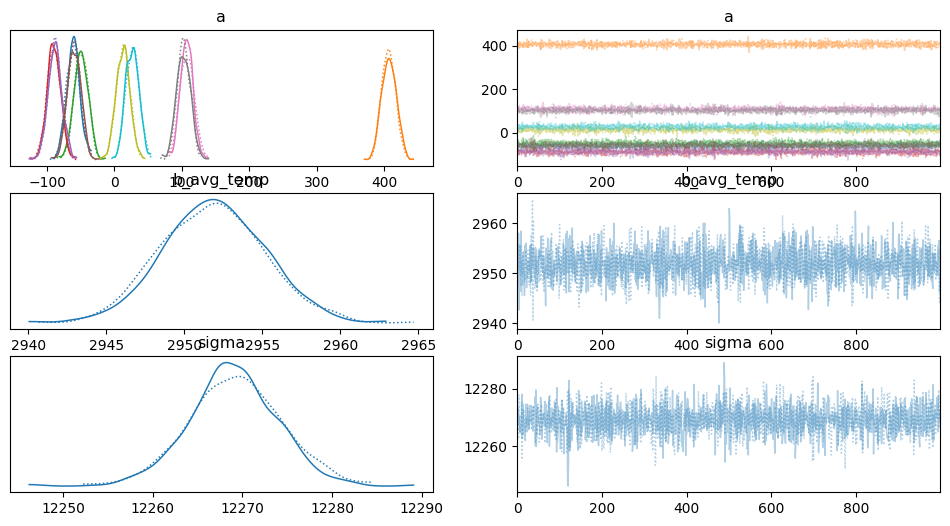

In [ ]:
az.plot_trace(trace)

In [ ]:
with hierarchical_model_v1:
  trace_hm = pm.sample_posterior_predictive(trace)

Output()

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
with pm.Model() as hierarchical_model_v2:
    b_avg_temp = pm.Normal('b_avg_temp', mu=0, sigma=10, shape = 10)
    sigma = pm.HalfNormal('sigma', sigma=10, shape = 10)

    a = pm.Normal('a', mu=0, sigma=10, shape=10)

    mu = a[alimentos] + b_avg_temp[alimentos]  * avg_temp

    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma[alimentos], observed=hg_ha_yield)

In [ ]:
with hierarchical_model_v2:
  trace_2 = pm.sample()

Output()

In [ ]:
pm.summary(trace_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],208.456,9.846,190.088,227.213,0.154,0.110,4040.0,1368.0,1.00
a[1],415.547,9.805,397.782,434.403,0.164,0.116,3564.0,1245.0,1.00
a[2],175.744,9.859,157.794,193.967,0.154,0.110,4093.0,1396.0,1.00
a[3],115.993,9.630,98.573,134.821,0.171,0.122,3185.0,1475.0,1.00
a[4],170.362,10.025,151.163,188.695,0.182,0.128,3071.0,1584.0,1.00
a[5],215.171,9.847,198.010,234.398,0.158,0.113,3956.0,1455.0,1.01
a[6],181.841,10.268,162.777,200.959,0.146,0.105,4920.0,1359.0,1.00
a[7],229.764,9.479,210.415,246.324,0.201,0.142,2230.0,1372.0,1.00
a[8],115.705,10.056,97.204,134.183,0.157,0.111,4053.0,1509.0,1.00
a[9],169.188,10.111,152.575,191.046,0.185,0.131,3014.0,1328.0,1.00


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b_avg_temp'}>,
        <Axes: title={'center': 'b_avg_temp'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

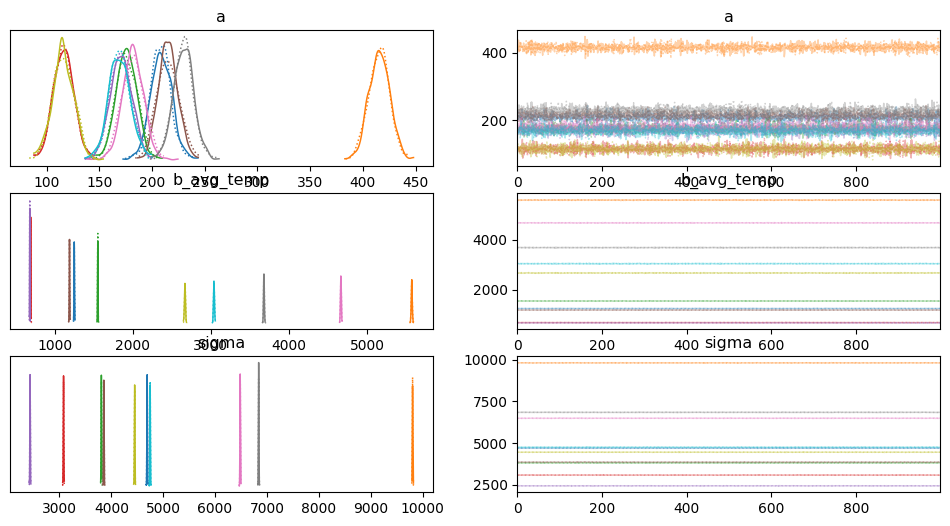

In [ ]:
az.plot_trace(trace_2)

In [ ]:
with hierarchical_model_v2:
  trace_hm_2 = pm.sample_posterior_predictive(trace_2)

Output()

In [ ]:
with pm.Model() as linear_model:
    a = pm.Normal('a', mu=0, sigma=10)
    b_avg_temp = pm.Normal('b_avg_temp', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = a + b_avg_temp * avg_temp

    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=hg_ha_yield)

In [ ]:
with linear_model:
  trace_3 = pm.sample()

Output()

In [ ]:
pm.summary(trace_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,305.898,9.389,287.803,322.739,0.184,0.130,2595.0,1823.0,1.0
b_avg_temp,2940.754,3.269,2935.116,2946.988,0.058,0.041,3159.0,1663.0,1.0
sigma,12275.467,5.017,12265.768,12284.639,0.089,0.063,3197.0,1408.0,1.0


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b_avg_temp'}>,
        <Axes: title={'center': 'b_avg_temp'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

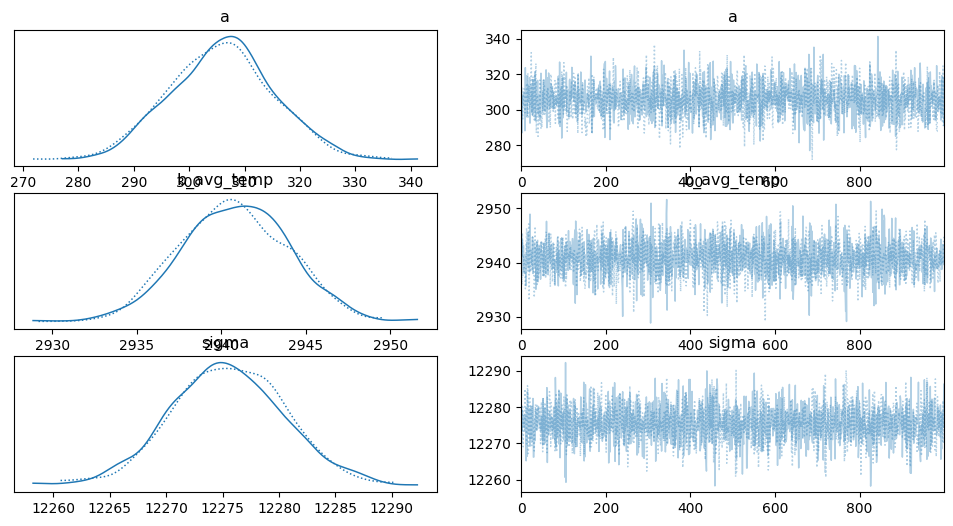

In [ ]:
az.plot_trace(trace_3)

In [ ]:
with linear_model:
  trace_hm_3 = pm.sample_posterior_predictive(trace_3)

Output()

In [ ]:
with hierarchical_model_v1:
    pm.compute_log_likelihood(trace)

with hierarchical_model_v2:
    pm.compute_log_likelihood(trace_2)

with linear_model:
    pm.compute_log_likelihood(trace_3)


Output()

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

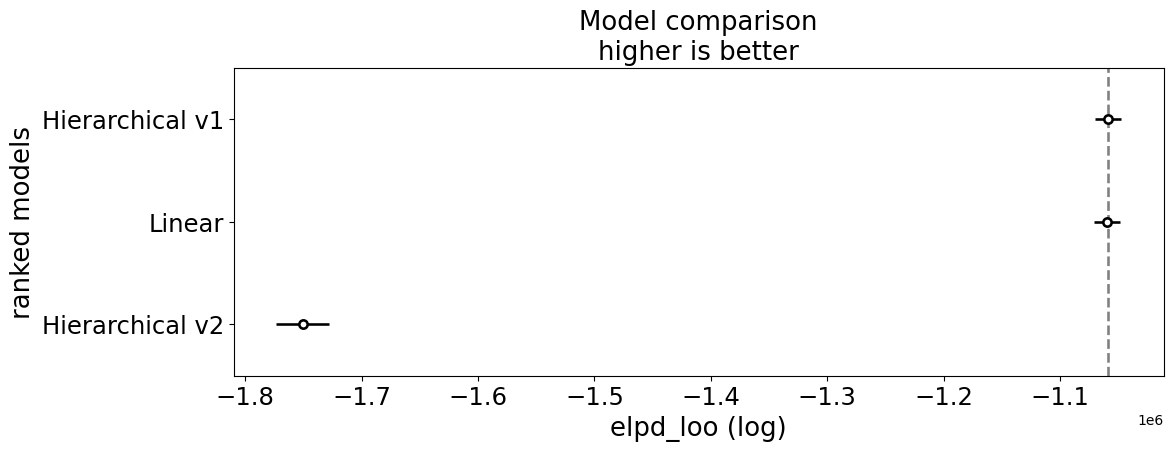

In [ ]:
model_compare = az.compare(
    {
        "Hierarchical v1": trace,
        "Hierarchical v2": trace_2,
        "Linear": trace_3
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

In [ ]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Hierarchical v1,0,-1.058742e+06,135.668092,0.000000,1.000000e+00,11464.377933,0.000000,False,log
Linear,1,-1.059493e+06,131.475961,750.857631,3.934910e-307,11466.729600,14.008376,False,log
Hierarchical v2,2,-1.750729e+06,1957.883946,691987.495083,0.000000e+00,23056.486811,15981.007683,True,log


O melhor modelo foi o Hierarchical v1